In [1]:
import os
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import pickle
import sys
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
sys.path.append('../src')
import P_random
import P_binary
import const as c
from astropy.coordinates import SkyCoord, ICRS, FK5
from astropy import units as u
import time
from astropy.table import Table

%matplotlib inline

In [2]:
AU_to_cm = 1.496e13               # AU to cm
pc_to_cm = 3.086e18               # pc to cm

In [3]:
folder = '../data/TGAS/'

TGAS = np.genfromtxt(open(folder + 'gaia_wide_binaries_TGAS_plx_exponential_cleaned.txt', 'rb'), comments='#', names=True)
TGAS_log_flat = np.genfromtxt(open(folder + 'gaia_wide_binaries_TGAS_plx_exponential_cleaned.txt', 'rb'), comments='#', names=True)
TGAS_power_law = np.genfromtxt(open(folder + 'gaia_wide_binaries_TGAS_plx_exponential_a_power_law_cleaned.txt', 'rb'), comments='#', names=True)

TGAS_good = TGAS[TGAS['P_posterior'] > 0.99]
TGAS_log_flat_good = TGAS_log_flat[TGAS_log_flat['P_posterior'] > 0.99]
TGAS_power_law_good = TGAS_power_law[TGAS_power_law['P_posterior'] > 0.99]

In [4]:
print TGAS.shape
print TGAS_good.shape
# print TGAS.dtype

print TGAS_log_flat.shape
print TGAS_power_law.shape

print len(TGAS_log_flat_good)
print len(TGAS_power_law_good)

(33169,)
(6072,)
(33169,)
(17895,)
6072
4715


In [9]:
TGAS_300pc = TGAS_good[TGAS_good['plx_1'] > 1.0e3/300.0]
TGAS_200pc = TGAS_good[TGAS_good['plx_1'] > 1.0e3/200.0]
TGAS_100pc = TGAS_good[TGAS_good['plx_1'] > 1.0e3/100.0]

In [10]:
# Read in sample from TGAS table
# Read in sample from TGAS table
dtype = [('ID','<i8'),('tyc','S11'),('hip','<i8'),('ra','<f8'),('dec','<f8'),('mu_ra','<f8'),('mu_dec','<f8'), \
     ('mu_ra_err','<f8'),('mu_dec_err','<f8'),('plx','<f8'),('plx_err','<f8'), \
     ('mu_ra_mu_dec_cov','<f8'),('mu_ra_plx_cov','<f8'),('mu_dec_plx_cov','<f8'),('d_Q','<f8'),('noise','<f8')]

tgas_full = np.array([], dtype=dtype)

for i in np.arange(1):
    if i < 10:
        filename = ('../data/TGAS/TgasSource_000-000-00' + str(i) + '.csv')
    else:
        filename = ('../data/TGAS/TgasSource_000-000-0' + str(i) + '.csv')

    print filename
    tgas_tmp = Table.read(filename, format='csv', guess=True)
    
    

    tgas = np.zeros(len(tgas_tmp), dtype=dtype)

                                                  # Gaia units
    tgas['ID'] = tgas_tmp['source_id']
    tgas['tyc'] = tgas_tmp['tycho2_id']
    tgas['hip'] = tgas_tmp['hip']
    tgas['ra'] = tgas_tmp['ra']                   # degrees
    tgas['dec'] = tgas_tmp['dec']                 # degrees
    tgas['mu_ra'] = tgas_tmp['pmra']              # mas/yr
    tgas['mu_ra_err'] = tgas_tmp['pmra_error']    # mas/yr
    tgas['mu_dec'] = tgas_tmp['pmdec']            # mas/yr
    tgas['mu_dec_err'] = tgas_tmp['pmdec_error']  # mas/yr
    tgas['plx'] = tgas_tmp['parallax']            # mas
    tgas['plx_err'] = tgas_tmp['parallax_error']  # mas
    tgas['mu_ra_mu_dec_cov'] = tgas_tmp['pmra_pmdec_corr']*tgas_tmp['pmra_error']*tgas_tmp['pmdec_error']
    tgas['mu_ra_plx_cov'] = tgas_tmp['parallax_pmra_corr']*tgas_tmp['parallax_error']*tgas_tmp['pmra_error']
    tgas['mu_dec_plx_cov'] = tgas_tmp['parallax_pmdec_corr']*tgas_tmp['parallax_error']*tgas_tmp['pmdec_error']
    tgas['d_Q'] = tgas_tmp['astrometric_delta_q']
    tgas['noise'] = tgas_tmp['astrometric_excess_noise_sig']

    tgas_full = np.append(tgas_full, tgas)



../data/TGAS/TgasSource_000-000-000.csv


### First, let's look at the distribution of posterior probabilities

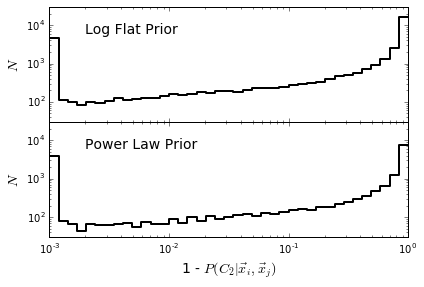

In [68]:
fig, ax = plt.subplots(2, 1, figsize=(6,4))

# plt.hist(TGAS_log_flat['P_posterior'], bins=30, linestyle='dashed', histtype='step', color='k', log=True)
# plt.hist(TGAS_power_law['P_posterior'], bins=30, linestyle='dotted', histtype='step', color='k', log=True)


## Log flat prior
TGAS_tmp = np.copy(TGAS_log_flat)
TGAS_tmp['P_posterior'][TGAS_tmp['P_posterior'] > 1.0-1.0e-3] = 1.0-1.0e-3

xmin, xmax = -3.0, 0.0
bins = np.linspace(xmin, xmax, 40)
center = (bins[:-1] + bins[1:]) / 2
vals, bins = np.histogram(np.log10(1.0 - TGAS_tmp['P_posterior']), bins=bins)
left,right = 10**bins[:-1],10**bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([vals,vals]).T.flatten()
ax[0].plot(X, Y, color='k', linewidth=2.0, label='Log Flat Prior')


## Power law prior
TGAS_tmp = np.copy(TGAS_power_law)
TGAS_tmp['P_posterior'][TGAS_tmp['P_posterior'] > 1.0-1.0e-3] = 1.0-1.0e-3

xmin, xmax = -3.0, 0.0
bins = np.linspace(xmin, xmax, 40)
center = (bins[:-1] + bins[1:]) / 2
vals, bins = np.histogram(np.log10(1.0 - TGAS_tmp['P_posterior']), bins=bins)
left,right = 10**bins[:-1],10**bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([vals,vals]).T.flatten()
ax[1].plot(X, Y, color='k', linewidth=2.0, label='Power Law Prior')





ax[1].set_xlabel(r'1 - $P(C_2 | \vec{x}_i, \vec{x}_j)$', fontsize=14)
#plt.xlabel(r'$P\ (C_2 | \vec{x}_i, \vec{x}_j)$', fontsize=14)


for i in np.arange(2):
    ax[i].set_ylabel(r'$N$', fontsize=14)
    ax[i].set_ylim(3.0e1, 3.0e4)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    
ax[0].set_xticklabels([])

ax[0].text(2.0e-3, 6.0e3, 'Log Flat Prior', fontsize=14)
ax[1].text(2.0e-3, 6.0e3, 'Power Law Prior', fontsize=14)


#plt.tight_layout()
plt.subplots_adjust(hspace=0, bottom=0.15, right=0.95, top=0.95, left=0.12)
plt.savefig('../figures/TGAS_P_posterior_dist.pdf')
#plt.show()

### Now, the distance distribution

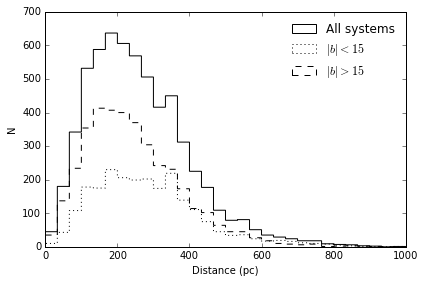

In [52]:
#fig, ax = plt.subplots(2, 1, figsize=(5, 6))


# Calculate distance from average parallaxes, weighted by uncertainties
dist = np.zeros(len(TGAS_good))
for i in np.arange(len(TGAS_good)):
    vals = [TGAS_good['plx_1'][i],TGAS_good['plx_2'][i]]
    weights = [1.0/TGAS_good['plx_err_1'][i]**2,1.0/TGAS_good['plx_err_2'][i]**2]
    dist[i] = 1.0e3/np.average(vals, weights=weights)



# Determine pairs in halo and in Galactic plane
coor_icrs = SkyCoord(ra=TGAS_good['ra_1']*u.degree, dec=TGAS_good['dec_1']*u.degree, frame='icrs')
idx_plane = np.where(abs(coor_icrs.galactic.b.degree) < 15.0)
idx_halo = np.where(abs(coor_icrs.galactic.b.degree) >= 15.0)

# Plot different pairs
plt.hist(dist, histtype='step', color='k', bins=30, 
         range=(0, 1000), label='All systems')
plt.hist(dist[idx_plane], histtype='step', color='k', bins=30, 
         range=(0, 1000), linestyle='dotted', label=r'$|b|<15$')
plt.hist(dist[idx_halo], histtype='step', color='k', bins=30, 
         range=(0, 1000), linestyle='dashed', label=r'$|b|>15$')

plt.xlabel('Distance (pc)')
plt.ylabel('N')

plt.legend(frameon=False)





# dist_kde = gaussian_kde(dist[dist<200.0], bw_method=0.1)

# tmp_dist = np.linspace(0.0, 225.0, 200)
# dist_out = dist_kde.evaluate((tmp_dist))

# ax[1].hist(dist[dist<200.0], normed=True, histtype='step', color='k', bins=25, range=(0,225.0))
# ax[1].plot(tmp_dist, dist_out, color='r', label='KDE estimate')
# ax[1].set_xlabel('Distance (pc)')
# ax[1].set_yticklabels([])
# ax[1].legend(loc=2, frameon=False)





plt.tight_layout()
plt.savefig('../figures/TGAS_distance_gal_b.pdf')
#plt.show()

In [66]:
def get_integrand(dist, angle, dist_max):
    """ Integrand. Distance in pc, angle in asec """
    
    proj_sep = (angle/3600.0*np.pi/180.0) * (dist*c.pc_to_cm/c.Rsun_to_cm)
        
    prob_proj_sep = np.exp(proj_sep_kde.score_samples(np.log10(proj_sep*np.ones(1)[:, np.newaxis]))) / (proj_sep*np.log(10.))
    
    return prob_proj_sep * 3.0 * dist**3 * dist_max**(-3)

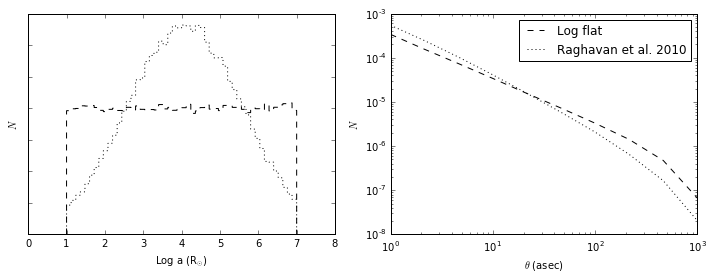

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

dist_min = 1.0
nsamples = 10
xmin = 1.0
xmax = 1000.0

log_angles = np.linspace(np.log10(xmin), np.log10(xmax), nsamples)
angles = 10**log_angles




# Flat in log-space, thermal e
P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='log_flat')

tmp_a = P_binary.get_a(num_sys=100000, prob='log_flat')
ax[0].hist(np.log10(tmp_a), histtype='step', color='k', bins=50, linestyle='dashed', label='Log flat')

proj_sep_kde is None
kwargs = {'kernel':'tophat'}
proj_sep_kde = KernelDensity(bandwidth=0.2, **kwargs)
proj_sep_kde.fit( np.log10(P_binary.binary_set['proj_sep'][:, np.newaxis] ))


P_theta = np.zeros(nsamples)
dist_max = 100.0
for i, ang in zip(np.arange(nsamples), angles):
    args = ang, dist_max
    P_theta[i], err_theta = quad(get_integrand, dist_min, dist_max, args=args)

ax[1].plot(angles, P_theta, color='k', linestyle='dashed', label='Log flat')






# Log-normal, thermal e
P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='raghavan')

tmp_a = P_binary.get_a(num_sys=100000, prob='raghavan')
ax[0].hist(np.log10(tmp_a), histtype='step', color='k', bins=50, linestyle='dotted', label='Raghavan et al. 2010')

proj_sep_kde is None
kwargs = {'kernel':'tophat'}
proj_sep_kde = KernelDensity(bandwidth=0.2, **kwargs)
proj_sep_kde.fit( np.log10(P_binary.binary_set['proj_sep'][:, np.newaxis] ))


P_theta = np.zeros(nsamples)
dist_max = 100.0
for i, ang in zip(np.arange(nsamples), angles):
    args = ang, dist_max
    P_theta[i], err_theta = quad(get_integrand, dist_min, dist_max, args=args)

ax[1].plot(angles, P_theta, color='k', linestyle='dotted', label='Raghavan et al. 2010')



ax[0].set_xlim(0, 8)
ax[0].set_xlabel(r'Log a (R$_{\odot}$)')
ax[0].set_ylabel(r'$N$')
ax[0].set_yticklabels([])


ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_xlim(xmin, xmax)
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\theta$ (asec)')
ax[1].set_ylabel(r'$N$')
#ax[1].set_yticklabels([])

plt.tight_layout()
#plt.savefig('../figures/proj_sep_dist.pdf')
plt.show()

In [75]:
folder = '../data/TGAS/'

TGAS_new = np.genfromtxt(open(folder + 'gaia_wide_binaries_TGAS_plx_exponential_cleaned.txt', 'rb'), comments='#', names=True)
TGAS_old = np.genfromtxt(open(folder + 'gaia_wide_binaries_TGAS_plx_empirical_cleaned.txt', 'rb'), comments='#', names=True)

In [76]:
dtype = [('source_id_1','<i8'),('source_id_2','<i8'),('P_posterior_1','f8'),('P_posterior_2','f8'),
         ('idx_1','i8'), ('idx_2','i8')]
compare = np.zeros(len(TGAS_new), dtype=dtype)
compare_zero = np.zeros(1, dtype=dtype)

compare['source_id_1'] = TGAS_new['source_ID_1']
compare['source_id_2'] = TGAS_new['source_ID_2']
compare['P_posterior_1'] = TGAS_new['P_posterior']
compare['idx_1'] = np.arange(len(TGAS_new))
compare['idx_2'] = -1* np.ones(len(TGAS_new))



for i in np.arange(len(TGAS_old)):
#for i in np.arange(40):
    idx1 = np.where(TGAS_old[i]['source_ID_1'] == compare['source_id_1']) 

    if len(idx1[0]) < 1: 
        compare = np.append(compare, compare_zero)
        compare[-1]['source_id_1'] = TGAS_old['source_ID_1'][i]
        compare[-1]['source_id_2'] = TGAS_old['source_ID_2'][i]
        compare[-1]['P_posterior_2'] = TGAS_old['P_posterior'][i]
        compare[-1]['idx_1'] = -1
        compare[-1]['idx_2'] = i
        continue

    j_good = -1

    for j in idx1[0]:
        if TGAS_old[i]['source_ID_2'] == compare[j]['source_id_2']:
            j_good = j

    if j_good == -1:
        compare = np.append(compare, compare_zero)
        compare[-1]['source_id_1'] = TGAS_old['source_ID_1'][i]
        compare[-1]['source_id_2'] = TGAS_old['source_ID_2'][i]
        compare[-1]['P_posterior_2'] = TGAS_old['P_posterior'][i]
        compare[-1]['idx_1'] = -1
        compare[-1]['idx_2'] = i
    else:
        compare[j_good]['P_posterior_2'] = TGAS_old['P_posterior'][i]
        compare[j_good]['idx_2'] = i




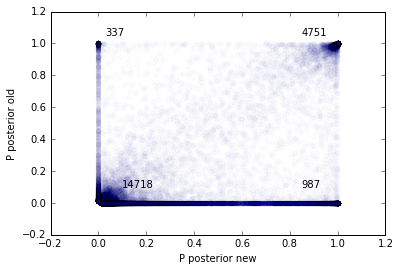

In [108]:
plt.scatter(compare['P_posterior_1'], compare['P_posterior_2'], alpha=0.01)

plt.xlabel('P posterior new')
plt.ylabel('P posterior old')

# Print numbers at bottom right and top left
idx_bottom_left = 0
idx_bottom_right = 0
idx_top_left = 0
idx_top_right = 0

for i in np.arange(len(compare)):
    
    if compare[i]['P_posterior_1'] > 0.99 and compare[i]['P_posterior_2'] > 0.99: 
        idx_top_right = np.append(idx_top_right, i)
    if compare[i]['P_posterior_1'] > 0.99 and compare[i]['P_posterior_2'] < 0.1: 
        idx_bottom_right = np.append(idx_bottom_right, i)
    if compare[i]['P_posterior_1'] < 0.1 and compare[i]['P_posterior_2'] > 0.99: 
        idx_top_left = np.append(idx_top_left, i)
    if compare[i]['P_posterior_1'] < 0.1 and compare[i]['P_posterior_2'] < 0.1: 
        idx_bottom_left = np.append(idx_bottom_left, i)

        
plt.text(0.85, 0.1, len(idx_bottom_right))
plt.text(0.1, 0.1, len(idx_bottom_left))
plt.text(0.03, 1.05, len(idx_top_left))
plt.text(0.85, 1.05, len(idx_top_right))


plt.show()

In [69]:
# Calculate distance from average parallaxes, weighted by uncertainties
dist = np.zeros(len(TGAS))
for i in np.arange(len(TGAS)):
    vals = [TGAS['plx_1'][i],TGAS['plx_2'][i]]
    weights = [1.0/TGAS['plx_err_1'][i]**2,1.0/TGAS['plx_err_2'][i]**2]
    dist[i] = 1.0e3/np.average(vals, weights=weights)
    
# Calculate the physical separation in AU
s = (TGAS['theta']*np.pi/180.0/3600.0) * dist * (c.pc_to_cm/c.AU_to_cm)

# Calculate the primary's proper motion
mu_1 = np.sqrt(TGAS['mu_ra_1']**2 + TGAS['mu_dec_1']**2)
delta_mu = np.sqrt((TGAS['mu_ra_1']-TGAS['mu_ra_2'])**2 + (TGAS['mu_dec_1']-TGAS['mu_dec_2'])**2)

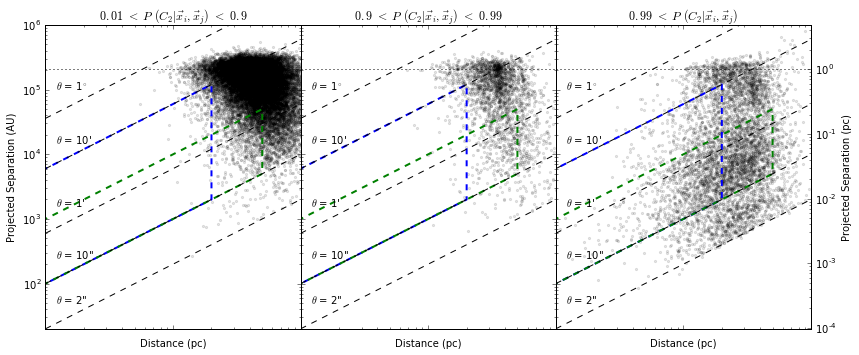

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))


tmp_x = 10**np.linspace(1,3,100)
tmp_y_2as = 2. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_10as = 10. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_60as = 60. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_600as = 600. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_1deg = (np.pi/180.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_10deg = 10.0 * (np.pi/180.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)


# all mu
idx = np.where(TGAS['P_posterior'] < 0.9)
ax[0].scatter(dist[idx], s[idx], marker='.', color='k', alpha=0.1, rasterized=True)
idx = np.intersect1d(np.where(TGAS['P_posterior'] > 0.9)[0], np.where(TGAS['P_posterior'] < 0.99)[0])
ax[1].scatter(dist[idx], s[idx], marker='.', color='k', alpha=0.1, rasterized=True)
idx = np.where(TGAS['P_posterior'] > 0.99)
ax[2].scatter(dist[idx], s[idx], marker='.', color='k', alpha=0.1, rasterized=True)



x_region = np.array([0.01, 200.0, 200.0, 0.01])
y_region = 600. * (np.pi/180.0/3600.0) * x_region * (c.pc_to_cm/c.AU_to_cm)
y_region[2] = 10. * (np.pi/180.0/3600.0) * x_region[2] * (c.pc_to_cm/c.AU_to_cm)
y_region[3] = 10. * (np.pi/180.0/3600.0) * x_region[3] * (c.pc_to_cm/c.AU_to_cm)
for j in np.arange(3):
    ax[j].plot(x_region, y_region, color='b', linewidth=2.0, linestyle='dashed')

    
x_region = np.array([0.01, 500.0, 500.0, 0.01])
y_region = 100. * (np.pi/180.0/3600.0) * x_region * (c.pc_to_cm/c.AU_to_cm)
y_region[2] = 10. * (np.pi/180.0/3600.0) * x_region[2] * (c.pc_to_cm/c.AU_to_cm)
y_region[3] = 10. * (np.pi/180.0/3600.0) * x_region[3] * (c.pc_to_cm/c.AU_to_cm)
for j in np.arange(3):
    ax[j].plot(x_region, y_region, color='g', linewidth=2.0, linestyle='dashed')





for j in np.arange(3):

    ax[j].plot(tmp_x, tmp_y_2as, color='k', linestyle='dashed')
    ax[j].text(12.0, 50., r'$\theta$ = 2"')
    ax[j].plot(tmp_x, tmp_y_10as, color='k', linestyle='dashed')
    ax[j].text(12.0, 250., r'$\theta$ = 10"')
    ax[j].plot(tmp_x, tmp_y_60as, color='k', linestyle='dashed')
    ax[j].text(12.0, 1600., r"$\theta$ = 1'")
    ax[j].plot(tmp_x, tmp_y_600as, color='k', linestyle='dashed')
    ax[j].text(12.0, 15000., r"$\theta$ = 10'")
    ax[j].plot(tmp_x, tmp_y_1deg, color='k', linestyle='dashed')
    ax[j].text(12.0, 1.0e5, r"$\theta$ = 1$^{\circ}$")

    ax[j].set_xlim(10.0, 1000.0)
    ax[j].set_ylim(20.0, 1.0e6)
    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    ax[j].axhline(1.0*c.pc_to_cm/c.AU_to_cm, color='k', linestyle='dotted')

    ax[j].set_xticklabels([])
    if j != 0:
        ax[j].set_yticklabels([])
        
    
    ax[j].set_xlabel("Distance (pc)")
    

ax2 = ax[2].twinx()
y2_min = ax[2].get_ylim()[0] * c.AU_to_cm/c.pc_to_cm
y2_max = ax[2].get_ylim()[1] * c.AU_to_cm/c.pc_to_cm
ax2.set_ylim(y2_min, y2_max)
ax2.set_yscale('log')
ax2.set_ylabel('Projected Separation (pc)')
    

ax[0].set_ylabel("Projected Separation (AU)")

ax[0].set_title(r'$0.01\ <\ P\ (C_2 | \vec{x}_i, \vec{x}_j)\ <\ 0.9$')
ax[1].set_title(r'$0.9\ <\ P\ (C_2 | \vec{x}_i, \vec{x}_j)\ <\ 0.99$')
ax[2].set_title(r'$0.99\ <\ P\ (C_2 | \vec{x}_i, \vec{x}_j)$')
# ax[0].text(90.0, 30.0, r'$P\ (C_2 | \vec{x}_i, \vec{x}_j)\ <\ 0.9$', fontsize=12.0)
# ax[1].text(40.0, 30.0, r'$0.9\ <\ P\ (C_2 | \vec{x}_i, \vec{x}_j)\ <\ 0.99$', fontsize=12.0)
# ax[2].text(90.0, 30.0, r'$0.99\ <\ P\ (C_2 | \vec{x}_i, \vec{x}_j)$', fontsize=12.0)


plt.tight_layout()
plt.subplots_adjust(wspace=0)    
plt.savefig('../figures/TGAS_dist_s_theta.pdf')
#plt.show()

In [72]:
# Calculate distance from average parallaxes, weighted by uncertainties
dist = np.zeros(len(TGAS_good))
for i in np.arange(len(TGAS_good)):
    vals = [TGAS_good['plx_1'][i],TGAS_good['plx_2'][i]]
    weights = [1.0/TGAS_good['plx_err_1'][i]**2,1.0/TGAS_good['plx_err_2'][i]**2]
    dist[i] = 1.0e3/np.average(vals, weights=weights)
    
# Calculate the physical separation in AU
s = (TGAS_good['theta']*np.pi/180.0/3600.0) * dist * (pc_to_cm/AU_to_cm)

In [73]:
print len(dist[dist<200.0])

2324


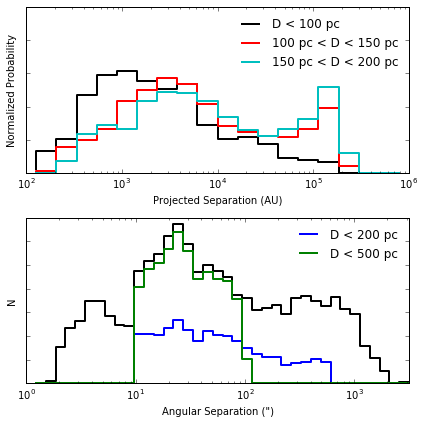

In [51]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))


tmp_x = 10**np.linspace(1,3,100)
#tmp_y_1as = (np.pi/180.0/3600.0) * tmp_x * (pc_to_cm/AU_to_cm)
tmp_y_2as = 2. * (np.pi/180.0/3600.0) * tmp_x * (pc_to_cm/AU_to_cm)
tmp_y_10as = 10. * (np.pi/180.0/3600.0) * tmp_x * (pc_to_cm/AU_to_cm)
tmp_y_60as = 60. * (np.pi/180.0/3600.0) * tmp_x * (pc_to_cm/AU_to_cm)
tmp_y_600as = 600. * (np.pi/180.0/3600.0) * tmp_x * (pc_to_cm/AU_to_cm)
tmp_y_1deg = (np.pi/180.0) * tmp_x * (pc_to_cm/AU_to_cm)
tmp_y_10deg = 10.0 * (np.pi/180.0) * tmp_x * (pc_to_cm/AU_to_cm)




# ax[0].scatter(dist, s, marker='.', color='k', alpha=0.1, rasterized=True)

# ax[0].plot(tmp_x, tmp_y_2as, color='k', linestyle='dashed')
# ax[0].text(12.0, 50., r'$\theta$ = 2"')
# ax[0].plot(tmp_x, tmp_y_10as, color='k', linestyle='dashed')
# ax[0].text(12.0, 250., r'$\theta$ = 10"')
# ax[0].plot(tmp_x, tmp_y_60as, color='k', linestyle='dashed')
# ax[0].text(12.0, 1600., r"$\theta$ = 1'")
# ax[0].plot(tmp_x, tmp_y_600as, color='k', linestyle='dashed')
# ax[0].text(12.0, 15000., r"$\theta$ = 10'")
# ax[0].plot(tmp_x, tmp_y_1deg, color='k', linestyle='dashed')
# ax[0].text(12.0, 1.0e5, r"$\theta$ = 1$^{\circ}$")


# ax[0].set_xlim(10.0, 1000.0)
# ax[0].set_ylim(20.0, 1.0e6)
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
# ax[0].set_xlabel("Distance (pc)")
# ax[0].set_ylabel("Projected Separation (AU)")
# ax[0].axhline(1.0*c.pc_to_cm/c.AU_to_cm, color='k', linestyle='dotted')

# ax2 = ax[0].twinx()
# ax2.set_ylim(ax[0].get_ylim()[0]*c.AU_to_cm/c.pc_to_cm, ax[0].get_ylim()[1]*c.AU_to_cm/c.pc_to_cm)
# ax2.set_yscale('log')
# ax2.set_ylabel("Projected Separation (pc)")


idx_100 = np.where(dist<100.0)
idx_100_150 = np.intersect1d(np.where(dist<150.0)[0], np.where(dist>100.0)[0])
idx_150_200 = np.intersect1d(np.where(dist<200.0)[0], np.where(dist>150.0)[0])
idx_200 = np.where(dist<200.0)

xmin, xmax = 2.0, 6.0
bins = np.linspace(xmin, xmax, 20)
center = (bins[:-1] + bins[1:]) / 2
vals, bins = np.histogram(np.log10(s[idx_100]), bins=bins, normed=True)
ax[0].plot(10**center, vals, ls='steps', color='k', linewidth=2.0, label='D < 100 pc')
vals, bins = np.histogram(np.log10(s[idx_100_150]), bins=bins, normed=True)
ax[0].plot(10**center, vals, ls='steps', color='r', linewidth=2.0, label='100 pc < D < 150 pc')
vals, bins = np.histogram(np.log10(s[idx_150_200]), bins=bins, normed=True)
ax[0].plot(10**center, vals, ls='steps', color='c', linewidth=2.0, label='150 pc < D < 200 pc')
ax[0].set_xscale('log')


bins = np.linspace(0, 3.5, 40)
vals, bins = np.histogram(np.log10(TGAS_good['theta']), bins=bins)
#center = (bins[:-1] + bins[1:]) / 2
ax[1].plot(10**bins[1:], vals, ls='steps', color='k', linewidth=2.0)


idx = reduce(np.intersect1d,
             [np.where(dist < 200.0)[0],
              np.where(TGAS_good['theta'] < 600.0)[0],
              np.where(TGAS_good['theta'] > 10.0)[0]])
vals, bins = np.histogram(np.log10(TGAS_good['theta'][idx]), bins=bins)
#center = (bins[:-1] + bins[1:]) / 2
ax[1].plot(10**bins[1:], vals, ls='steps', color='b', linewidth=2.0, label='D < 200 pc')


idx = reduce(np.intersect1d,
             [np.where(dist < 500.0)[0],
              np.where(TGAS_good['theta'] < 100.0)[0],
              np.where(TGAS_good['theta'] > 10.0)[0]])
vals, bins = np.histogram(np.log10(TGAS_good['theta'][idx]), bins=bins)
#center = (bins[:-1] + bins[1:]) / 2
ax[1].plot(10**bins[1:], vals, ls='steps', color='g', linewidth=2.0, label='D < 500 pc')




ax[1].set_xscale('log')
# ax[1].axvline(2.0, color='k', linestyle='dotted')
# ax[1].text(2.2, 3.0e-2, r'$\theta$ = 2"')
# ax[1].axvline(10.0, color='k', linestyle='dotted')
# ax[1].text(12.0, 3.0e-2, r'$\theta$ = 10"')
# ax[1].axvline(60.0, color='k', linestyle='dotted')
# ax[1].text(70.0, 3.0e-2, r"$\theta$ = 1'")
# ax[1].axvline(600.0, color='k', linestyle='dotted')
# ax[1].text(220.0, 3.0e-2, r"$\theta$ = 10'")
ax[1].set_xlim(1, 10**3.5)
ax[1].set_xlabel('Angular Separation (")')
ax[1].set_ylabel('N')
ax[1].set_yticklabels([])
ax[1].legend(loc=1, frameon=False)

ax[0].set_xlabel("Projected Separation (AU)")
ax[0].set_ylabel('Normalized Probability')
ax[0].set_yticklabels([])

ax[0].set_xlim(10.**xmin, 10.**xmax)
ax[0].set_ylim(0, 1.)
ax[0].legend(loc=1, frameon=False)

plt.tight_layout()
plt.savefig('../figures/TGAS_s_distribution.pdf')
#plt.show()

### Create the distance KDE

In [7]:
from scipy.stats import gaussian_kde
from scipy.integrate import quad

/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide


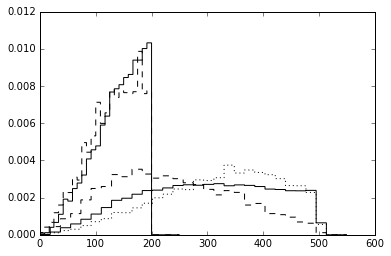

In [16]:
dist_tmp = 1.0e3/tgas_full['plx']
plt.hist(dist_tmp[dist_tmp<200.0], normed=True, histtype='step', color='k', bins=30, range=(0,250.0))
plt.hist(dist[dist<200.0], normed=True, histtype='step', color='k', bins=30, range=(0,250.0), linestyle='dashed')

plt.hist(dist_tmp[dist_tmp<500.0], normed=True, histtype='step', color='k', bins=30, range=(0,550.0))
plt.hist(dist[dist<500.0], normed=True, histtype='step', color='k', bins=30, range=(0,550.0), linestyle='dashed')
dist_all = 1.0e3/TGAS['plx_1']
plt.hist(dist_all[dist_all<500.0], normed=True, histtype='step', color='k', bins=30, range=(0,550.0), linestyle='dotted')

plt.show()

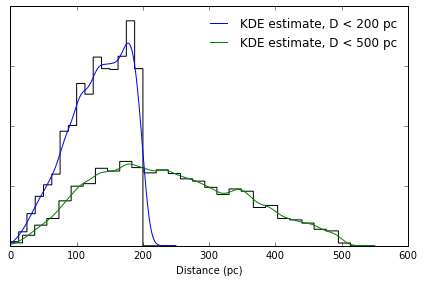

In [74]:
dist_200_kde = gaussian_kde(dist[dist<200.0], bw_method=0.2)
dist_500_kde = gaussian_kde(dist[dist<500.0], bw_method=0.1)

tmp_dist_200 = np.linspace(0.0, 250.0, 200)
tmp_dist_500 = np.linspace(0.0, 550.0, 200)
dist_200_out = dist_200_kde.evaluate((tmp_dist_200))
dist_500_out = dist_500_kde.evaluate((tmp_dist_500))

plt.plot(tmp_dist_200, dist_200_out, label='KDE estimate, D < 200 pc')
plt.hist(dist[dist<200.0], normed=True, histtype='step', color='k', bins=20, range=(0,250.0))

plt.plot(tmp_dist_500, dist_500_out, label='KDE estimate, D < 500 pc')
plt.hist(dist[dist<500.0], normed=True, histtype='step', color='k', bins=30, range=(0,550.0))

plt.xlabel('Distance (pc)')
plt.yticks(np.linspace(0.,0.01,5),[])

plt.legend(frameon=False)

plt.tight_layout()
plt.savefig('../figures/TGAS_distance_KDE.pdf')
#plt.show()

### Create the log-flat and log-normal KDEs

In [19]:
def calc_integrand(dist, theta, dist_kde, s_kde):
    """
    This function is to calculate the integrand for the integral over distance
    
    Parameters
    ----------
    dist : float
        Distance (pc)
    theta : float
        Angular separation (arcsec)
    dist_kde : scipy gaussian_kde
        KDE based on the distance distribution observed
    s_kde : scipy gaussian_kde
        KDE based on a particular binary population model
        
    Returns
    -------
    integrand : float
        Integrand of the equation
    
    """
    
    # Get the separation in Rsun
    s = (theta / 3600.0 * np.pi/180.0) * (dist * c.pc_to_cm / c.Rsun_to_cm)
        
    # Get probability from KDE - KDE is in log-space
    P_s = s_kde.evaluate((np.log10(s))) / s / np.log(10.)

    # Projected separation is above 1.0e7 Rsun
    P_s[np.where(s > 4.41e7)] = 0.0

#     # Calculate normalization constant
#     s_min = 10.0 * (1.0/3600.0 * np.pi/180.0) * dist * (c.pc_to_cm / c.Rsun_to_cm)
#     s_max = np.min([1.0 * (np.pi/180.0) * dist * (c.pc_to_cm / c.Rsun_to_cm), 4.41e7])
#     norm = 1.0 / calc_P_s_norm(s_min, s_max, s_kde)[0]
    
    # Get the distance probability
    P_dist = dist_kde.evaluate((dist))

    # Calculate integrand
    integrand = P_s * dist * P_dist# * norm

    return integrand



def calc_integral(theta, dist_min, dist_max, dist_kde, s_kde):
    """
    Calculate the integral over distance of all binaries that 
    could match the observed angular separation, theta.
    
    Parameters
    ----------
    theta : float
        Angular separation (asec)
    dist_min, dist_max : float
        Min, max distance of integration
    dist_kde : scipy gaussian_kde
        KDE to represent distance distribution of a sample
    s_kde : scipy gaussian_kde
        KDE to represent projected physical separation distribution of a binary population

    Returns
    -------
    P_theta : float
        Value of integration
    """
    
    args = theta, dist_kde, s_kde
        
    val = quad(calc_integrand, dist_min, dist_max, args=args, epsrel=1.0e-4)
    
    return val[0]



In [20]:
def calc_theta_norm(theta_min, theta_max, dist_min, dist_max, dist_kde, s_kde):
    
    args = dist_min, dist_max, dist_kde, s_kde
    
    norm = quad(calc_integral, theta_min, theta_max, args=args)
    
    return norm[0]
    

In [52]:
start_time = time.time()
print calc_theta_norm(10.0, 600.0, 0.0, 200.0, dist_kde, log_normal_sep_kde)
print "Elapsed time:", time.time() - start_time

(0.000772853919443737, 3.886073505010638e-10)
None
Elapsed time: 64.4300749302


In [21]:
def calc_P_s_norm_integrand(s, s_kde):
    
    # Get probability from KDE - KDE is in log-space
    P_s = s_kde.evaluate((np.log10(s))) / s / np.log(10.)

    return P_s


def calc_P_s_norm(s_min, s_max, s_kde):
    """
    Units in Rsun
    """
    
    args = s_kde
    
    P_s_norm = quad(calc_P_s_norm_integrand, s_min, s_max, args=args, epsrel=1.0e-3)
    
    return P_s_norm

In [43]:
start_time = time.time()

distance = 100.0  # pc
s_min = 10.0 * (1.0/3600.0 * np.pi/180.0) * distance * (c.pc_to_cm / c.Rsun_to_cm)
s_max = np.min([1.0 * (np.pi/180.0) * distance * (c.pc_to_cm / c.Rsun_to_cm), 4.41e7])

print s_min*c.Rsun_to_cm/c.AU_to_cm, s_max*c.Rsun_to_cm/c.AU_to_cm
print calc_P_s_norm(s_min, s_max, log_normal_sep_kde)
print calc_P_s_norm(s_min, s_max, log_flat_sep_kde)

dist_min, dist_max = 0.0, 200.0
print calc_integral(100.0, dist_min, dist_max, dist_kde, log_normal_sep_kde)

print "Elapsed time:", time.time() - start_time

1000.09025395 206202.874332
(0.19081183729165174, 9.626976251000952e-05)
(0.32852519354131965, 1.3530371139652093e-05)
(8.844060277463742e-06, 1.2363125881115812e-08)
Elapsed time: 106.662951946


In [12]:
dist_min = 0.0
dist_max = 200.0

theta_min = 10.0 # 2 arcsec
theta_max = 3600.0 # 1 degree

s_min = (theta_min / 3600.0 * np.pi/180.0) * (c.pc_to_cm / c.Rsun_to_cm) 
s_max = (theta_max / 3600.0 * np.pi/180.0) * (c.pc_to_cm / c.Rsun_to_cm) 

print s_min, s_max

2138.86350236 769990.860851


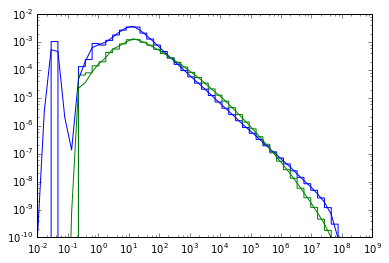

In [22]:
bins = 10**np.linspace(-2,9,50)

P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='log_flat')
log_flat_sep_kde = gaussian_kde(np.log10(P_binary.binary_set['proj_sep']), bw_method=0.05)
plt.hist(P_binary.binary_set['proj_sep'], bins=bins, histtype='step', normed=True)
prob_kde = log_flat_sep_kde.evaluate((np.log10(bins))) / bins / np.log(10.)
plt.plot(bins, prob_kde, color='b')


P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='raghavan')
log_normal_sep_kde = gaussian_kde(np.log10(P_binary.binary_set['proj_sep']), bw_method=0.05)


plt.hist(P_binary.binary_set['proj_sep'], bins=bins, histtype='step', normed=True)
prob_kde = log_normal_sep_kde.evaluate((np.log10(bins))) / bins / np.log(10.)
plt.plot(bins, prob_kde, color='g')

plt.xlim(10**(-2),10**9)
plt.ylim(1.0e-10, 1.0e-2)

plt.xscale('log')
plt.yscale('log')

plt.show()

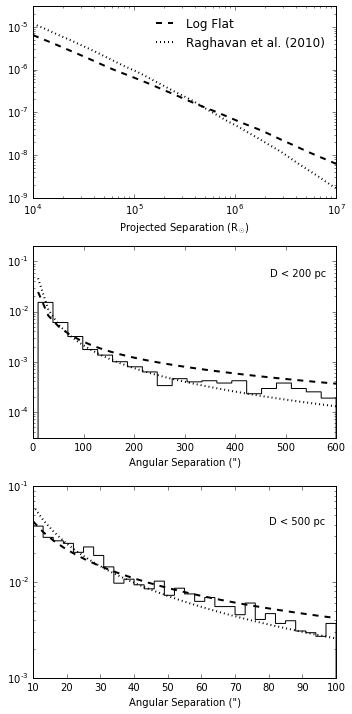

In [68]:
fig, ax = plt.subplots(3, 1, figsize=(5, 10))



idx_100 = np.where(dist<100.0)
idx_100_150 = np.intersect1d(np.where(dist<150.0)[0], np.where(dist>100.0)[0])
idx_150_200 = np.intersect1d(np.where(dist<200.0)[0], np.where(dist>150.0)[0])
idx_200 = np.where(dist<200.0)
idx_500 = np.where(dist<500.0)



proj_sep = 10**np.linspace(4,7, 100)
prob_kde =  log_flat_sep_kde.evaluate((np.log10(proj_sep))) / proj_sep / np.log(10.)
ax[0].plot(proj_sep, prob_kde, color='k', linestyle='dashed', label='Log Flat', linewidth=2.0)

prob_kde = log_normal_sep_kde.evaluate((np.log10(proj_sep))) / proj_sep / np.log(10.)
ax[0].plot(proj_sep, prob_kde, color='k', linestyle='dotted', label='Raghavan et al. (2010)', linewidth=2.0)
ax[0].set_xlabel(r'Projected Separation (R$_{\odot}$)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(1.0e-9, 3.0e-5)
ax[0].legend(loc=1, frameon=False)




num_samples = 30
xmin, xmax = 10, 600
dist_min, dist_max = 0.0, 200.0
idx_tmp = np.intersect1d(idx_200, np.where(TGAS_good['theta']>xmin)[0])
idx = np.intersect1d(idx_tmp, np.where(TGAS_good['theta']<xmax)[0])
tmp_theta = np.linspace(xmin, xmax, num_samples)
P_theta = np.zeros(num_samples)


# Log-flat distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_200_kde, log_flat_sep_kde)
theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_200_kde, log_flat_sep_kde)

#weight = 1.0/np.mean(P_theta)/(xmax-xmin)
ax[1].plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dashed', linewidth=2.0)
    
# Log-normal distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_200_kde, log_normal_sep_kde)
theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_200_kde, log_normal_sep_kde)
    
#weight = 1.0/np.mean(P_theta)/(xmax-xmin)
ax[1].plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dotted', linewidth=2.0)


# Our pairs
ax[1].hist(TGAS_good['theta'][idx], histtype='step', color='k', bins=20, log=True, normed=True,
         range=(xmin,xmax), label=r'$d < 200$ pc')

ax[1].set_xlabel('Angular Separation (")')
ax[1].set_yscale('log')

ax[1].set_ylim(3.0e-5, 2.0e-1)







num_samples = 30
xmin, xmax = 10, 100
dist_min, dist_max = 0.0, 500.0
idx_tmp = np.intersect1d(idx_500, np.where(TGAS_good['theta']>xmin)[0])
idx = np.intersect1d(idx_tmp, np.where(TGAS_good['theta']<xmax)[0])
tmp_theta = np.linspace(xmin, xmax, num_samples)
P_theta = np.zeros(num_samples)


# Log-flat distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_500_kde, log_flat_sep_kde)
theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_500_kde, log_flat_sep_kde)

#weight = 1.0/np.mean(P_theta)/(xmax-xmin)
ax[2].plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dashed', linewidth=2.0)
    
# Log-normal distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_500_kde, log_normal_sep_kde)
theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_500_kde, log_normal_sep_kde)
    
#weight = 1.0/np.mean(P_theta)/(xmax-xmin)
ax[2].plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dotted', linewidth=2.0)


# Our pairs
ax[2].hist(TGAS_good['theta'][idx], histtype='step', color='k', bins=30, log=True, normed=True,
         range=(xmin,xmax), label=r'$d < 500$ pc')

ax[2].set_xlabel('Angular Separation (")')
ax[2].set_yscale('log')
#ax[2].set_ylim(5.0e-3, 1.0e-1)
#ax[2].set_ylim(1.0e-5, 0.1)


ax[1].text(470.0, 0.05, 'D < 200 pc')
ax[2].text(80.0, 0.04, 'D < 500 pc')





# left, bottom, width, height = [0.5, 0.27, 0.4, 0.17]
# ax2 = fig.add_axes([left, bottom, width, height])


# num_samples = 30
# xmin, xmax = 10, 50
# idx_tmp = np.intersect1d(idx_200, np.where(TGAS_good['theta']>xmin)[0])
# idx = np.intersect1d(idx_tmp, np.where(TGAS_good['theta']<xmax)[0])
# tmp_theta = np.linspace(xmin, xmax, num_samples)
# P_theta = np.zeros(num_samples)


# # Log-flat distribution
# for i in np.arange(num_samples):
#     P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_kde, log_flat_sep_kde)
# theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_kde, log_flat_sep_kde)

# #weight = 1.0/np.mean(P_theta)/(xmax-xmin)
# ax2.plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dashed', linewidth=2.0)
    
# # Log-normal distribution
# for i in np.arange(num_samples):
#     P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_kde, log_normal_sep_kde)
# theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_kde, log_normal_sep_kde)
    
# #weight = 1.0/np.mean(P_theta)/(xmax-xmin)
# ax2.plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dotted', linewidth=2.0)


# # Our pairs
# ax2.hist(TGAS_good['theta'][idx], histtype='step', color='k', bins=20, log=False, normed=True,
#          range=(xmin,xmax), label=r'$d < 200$ pc')

# ax2.set_xlabel('Angular Separation (")')
# #ax2.set_yscale('log')
# ax2.set_ylim(0.0, 0.08)
# ax2.set_xticks([10, 20, 30, 40, 50])
# ax2.set_yticks([0.0, 0.04, 0.08])



plt.tight_layout()
plt.savefig('../figures/TGAS_theta_dist.pdf')
#plt.show()

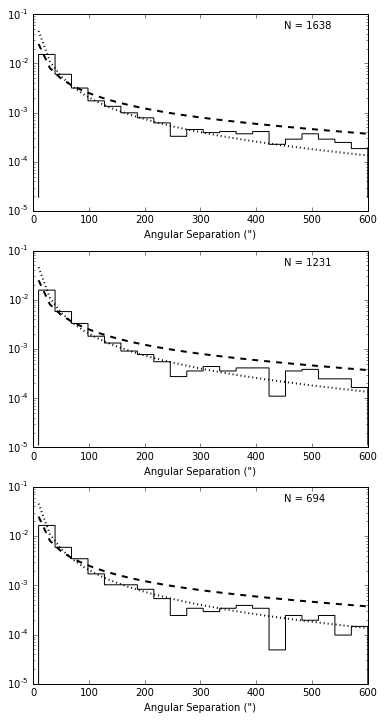

In [67]:
def plot_sample_angle(mu_limit, ax):

    dist_kde = gaussian_kde(dist[dist<200.0], bw_method=0.1)
    mu_1= np.sqrt(TGAS_good['mu_ra_1']**2 + TGAS_good['mu_dec_1']**2)
    idx_mu = np.intersect1d(np.where(dist<200.0)[0], np.where(mu_1 > mu_limit)[0])
    
    num_samples = 30
    xmin, xmax = 10, 600
    idx_tmp = np.intersect1d(idx_mu, np.where(TGAS_good['theta']>xmin)[0])
    idx = np.intersect1d(idx_tmp, np.where(TGAS_good['theta']<xmax)[0])
    tmp_theta = np.linspace(xmin, xmax, num_samples)
    P_theta = np.zeros(num_samples)


    # Log-flat distribution
    for i in np.arange(num_samples):
        P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_kde, log_flat_sep_kde)
    theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_kde, log_flat_sep_kde)
    
    ax.plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dashed', linewidth=2.0)
    
    
    # Log-normal distribution
    for i in np.arange(num_samples):
        P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_kde, log_normal_sep_kde)
    theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_kde, log_normal_sep_kde)
    
    ax.plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dotted', linewidth=2.0)


    
    
fig, ax = plt.subplots(3,1, figsize=(6,12))


xmin, xmax = 10, 600



# Mu > 0.0
mu_limit = 0.0
mu_1 = np.sqrt(TGAS_good['mu_ra_1']**2 + TGAS_good['mu_dec_1']**2)
idx = reduce(np.intersect1d, 
             [np.where(dist<200.0)[0],
              np.where(mu_1 > mu_limit)[0],
              np.where(TGAS_good['theta']>xmin)[0],
              np.where(TGAS_good['theta']<xmax)[0]])

plot_sample_angle(mu_limit, ax[0])
ax[0].hist(TGAS_good['theta'][idx], histtype='step', color='k', bins=20, log=True, normed=True,
         range=(xmin,xmax), label=r'$d < 200$ pc')
ax[0].text(450.0, 5.0e-2, 'N = '+str(len(idx)))



# Mu > 25.0
mu_limit = 25.0
mu_1 = np.sqrt(TGAS_good['mu_ra_1']**2 + TGAS_good['mu_dec_1']**2)
idx = reduce(np.intersect1d, 
             [np.where(dist<200.0)[0],
              np.where(mu_1 > mu_limit)[0],
              np.where(TGAS_good['theta']>xmin)[0],
              np.where(TGAS_good['theta']<xmax)[0]])

plot_sample_angle(mu_limit, ax[1])
ax[1].hist(TGAS_good['theta'][idx], histtype='step', color='k', bins=20, log=True, normed=True,
         range=(xmin,xmax), label=r'$d < 200$ pc')
ax[1].text(450.0, 5.0e-2, 'N = '+str(len(idx)))





# Mu > 50.0
mu_limit = 50.0
mu_1 = np.sqrt(TGAS_good['mu_ra_1']**2 + TGAS_good['mu_dec_1']**2)
idx = reduce(np.intersect1d, 
             [np.where(dist<200.0)[0],
              np.where(mu_1 > mu_limit)[0],
              np.where(TGAS_good['theta']>xmin)[0],
              np.where(TGAS_good['theta']<xmax)[0]])

plot_sample_angle(mu_limit, ax[2])
ax[2].hist(TGAS_good['theta'][idx], histtype='step', color='k', bins=20, log=True, normed=True,
         range=(xmin,xmax), label=r'$d < 200$ pc')
ax[2].text(450.0, 5.0e-2, 'N = '+str(len(idx)))



for i in np.arange(3):
    ax[i].set_xlabel('Angular Separation (")')
    ax[i].set_yscale('log')
    ax[i].set_ylim(1.0e-5, 1.0e-1)

plt.show()



### Repeat above plots, but for a zero eccentricity model

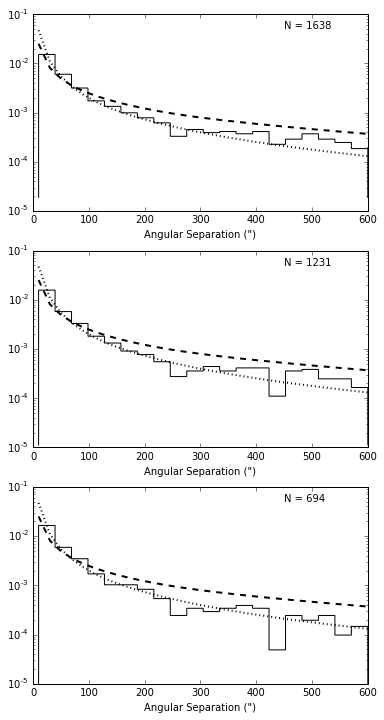

In [65]:
P_binary.generate_binary_set(num_sys=100000, ecc_prob='circular', a_prob='raghavan')
log_normal_circular_sep_kde = gaussian_kde(np.log10(P_binary.binary_set['proj_sep']), bw_method=0.05)

P_binary.generate_binary_set(num_sys=100000, ecc_prob='circular', a_prob='log_flat')
log_flat_circular_sep_kde = gaussian_kde(np.log10(P_binary.binary_set['proj_sep']), bw_method=0.05)


def plot_sample_angle(mu_limit, ax):

    dist_kde = gaussian_kde(dist[dist<200.0], bw_method=0.1)
    mu_1= np.sqrt(TGAS_good['mu_ra_1']**2 + TGAS_good['mu_dec_1']**2)
    idx_mu = np.intersect1d(np.where(dist<200.0)[0], np.where(mu_1 > mu_limit)[0])
    
    num_samples = 30
    xmin, xmax = 10, 600
    idx_tmp = np.intersect1d(idx_mu, np.where(TGAS_good['theta']>xmin)[0])
    idx = np.intersect1d(idx_tmp, np.where(TGAS_good['theta']<xmax)[0])
    tmp_theta = np.linspace(xmin, xmax, num_samples)
    P_theta = np.zeros(num_samples)


    # Log-flat distribution
    for i in np.arange(num_samples):
        P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_kde, log_flat_circular_sep_kde)
    theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_kde, log_flat_circular_sep_kde)
    
    ax.plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dashed', linewidth=2.0)
    
    
    # Log-normal distribution
    for i in np.arange(num_samples):
        P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_kde, log_normal_circular_sep_kde)
    theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_kde, log_normal_circular_sep_kde)
    
    ax.plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dotted', linewidth=2.0)


    
    
fig, ax = plt.subplots(3,1, figsize=(6,12))


xmin, xmax = 10, 600



# Mu > 0.0
mu_limit = 0.0
mu_1 = np.sqrt(TGAS_good['mu_ra_1']**2 + TGAS_good['mu_dec_1']**2)
idx = reduce(np.intersect1d, 
             [np.where(dist<200.0)[0],
              np.where(mu_1 > mu_limit)[0],
              np.where(TGAS_good['theta']>xmin)[0],
              np.where(TGAS_good['theta']<xmax)[0]])

plot_sample_angle(mu_limit, ax[0])
ax[0].hist(TGAS_good['theta'][idx], histtype='step', color='k', bins=20, log=True, normed=True,
         range=(xmin,xmax), label=r'$d < 200$ pc')
ax[0].text(450.0, 5.0e-2, 'N = '+str(len(idx)))



# Mu > 25.0
mu_limit = 25.0
mu_1 = np.sqrt(TGAS_good['mu_ra_1']**2 + TGAS_good['mu_dec_1']**2)
idx = reduce(np.intersect1d, 
             [np.where(dist<200.0)[0],
              np.where(mu_1 > mu_limit)[0],
              np.where(TGAS_good['theta']>xmin)[0],
              np.where(TGAS_good['theta']<xmax)[0]])

plot_sample_angle(mu_limit, ax[1])
ax[1].hist(TGAS_good['theta'][idx], histtype='step', color='k', bins=20, log=True, normed=True,
         range=(xmin,xmax), label=r'$d < 200$ pc')
ax[1].text(450.0, 5.0e-2, 'N = '+str(len(idx)))




# Mu > 50.0
mu_limit = 50.0
mu_1 = np.sqrt(TGAS_good['mu_ra_1']**2 + TGAS_good['mu_dec_1']**2)
idx = reduce(np.intersect1d, 
             [np.where(dist<200.0)[0],
              np.where(mu_1 > mu_limit)[0],
              np.where(TGAS_good['theta']>xmin)[0],
              np.where(TGAS_good['theta']<xmax)[0]])

plot_sample_angle(mu_limit, ax[2])
ax[2].hist(TGAS_good['theta'][idx], histtype='step', color='k', bins=20, log=True, normed=True,
         range=(xmin,xmax), label=r'$d < 200$ pc')
ax[2].text(450.0, 5.0e-2, 'N = '+str(len(idx)))



for i in np.arange(3):
    ax[i].set_xlabel('Angular Separation (")')
    ax[i].set_yscale('log')
    ax[i].set_ylim(1.0e-5, 1.0e-1)

plt.show()

